In [1]:
!pip install rdkit --pre deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 429.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
"""
DeepChem Model Optimization with PyTorch

This script demonstrates how to optimize a DeepChem model using various PyTorch techniques:
1. Using torch.compile for improved performance
2. Analyzing the compilation process and Inductor backend
3. Identifying bottlenecks in the training pipeline
4. Applying optimization techniques like mixed precision, quantization, and knowledge distillation
"""

import deepchem as dc
import numpy as np
import torch
import time
import os
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity
import deepchem.models.losses as losses
from deepchem.models.optimizers import Adam

from torch.amp import autocast, GradScaler

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
import wandb
wandb.init(project="prototype",
           config={
               "model": "MultitaskClassifier",
               "optimizations": ["torch.compile", "quantization", "distillation"],
               "dataset": "Tox21"
           })

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sk5499 (hpml-proj-deepchem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
# Set random seed for reproducibility
np.random.seed(100)
torch.manual_seed(100)

In [7]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [8]:
# Step 1: Load a dataset from DeepChem
print("Loading Tox21 dataset...")
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()
train_dataset, valid_dataset, test_dataset = tox21_datasets

Loading Tox21 dataset...


In [9]:
# Step 2: Define a simple model architecture
n_tasks = len(tox21_tasks)
n_features = train_dataset.X.shape[1]
print(f"Dataset has {n_tasks} tasks and {n_features} features")

# Create a simple multilayer perceptron model
model = dc.models.MultitaskClassifier(
    n_tasks=n_tasks,
    n_features=n_features,
    layer_sizes=[1000, 500],
    dropouts=[0.25, 0.25],
    learning_rate=0.001
)

Dataset has 12 tasks and 1024 features


In [10]:
# Step 3: Baseline training and evaluation
print("\n--- Baseline Model Performance ---")
start_time = time.time()
# Train for a small number of epochs for demonstration
model.fit(train_dataset, nb_epoch=10)
baseline_train_time = time.time() - start_time

# Evaluate model
baseline_scores = model.evaluate(test_dataset, metrics=[dc.metrics.Metric(dc.metrics.roc_auc_score)])
print(f"Baseline ROC-AUC: {baseline_scores['roc_auc_score']}")
print(f"Baseline training time: {baseline_train_time:.2f} seconds")


--- Baseline Model Performance ---
Baseline ROC-AUC: 0.6849960208233927
Baseline training time: 2.62 seconds


In [11]:
# Step 4: Apply torch.compile to the model
print("\n--- Applying torch.compile ---")
# Get the PyTorch model from the DeepChem wrapper
torch_model = model.model

# Create a compiled version of the model
if hasattr(torch, 'compile'):  # Check if torch.compile is available (PyTorch 2.0+)
    compiled_model = torch.compile(torch_model, backend="inductor")
    model.model = compiled_model

    # Train with compiled model
    start_time = time.time()
    model.fit(train_dataset, nb_epoch=10)
    compiled_train_time = time.time() - start_time

    # Evaluate compiled model
    compiled_scores = model.evaluate(test_dataset, metrics=[dc.metrics.Metric(dc.metrics.roc_auc_score)])
    print(f"Compiled model ROC-AUC: {compiled_scores['roc_auc_score']}")
    print(f"Compiled model training time: {compiled_train_time:.2f} seconds")
    print(f"Speedup: {baseline_train_time / compiled_train_time:.2f}x")
else:
    print("torch.compile not available in this PyTorch version. Requires PyTorch 2.0+")


--- Applying torch.compile ---


W0418 18:45:50.667000 655 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Compiled model ROC-AUC: 0.6691060087604739
Compiled model training time: 17.07 seconds
Speedup: 0.15x


In [12]:
# Step 5: Profile the model to identify bottlenecks
print("\n--- Profiling Model Performance ---")

def profile_model(model, dataset, name):
    # Create a small batch for profiling
    for X_batch, y_batch, w_batch, ids_batch in dataset.iterbatches(batch_size=32, pad_batches=True):
         # Get the device the model is on
        device = next(model.model.parameters()).device

        # Move tensors to the same device as the model
        X_tensor = torch.tensor(X_batch, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_batch, dtype=torch.float32).to(device)

        # Profile forward pass
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                    record_shapes=True) as prof:
            with record_function(f"{name}_forward"):
                model.model(X_tensor)

        print(f"\n{name} Forward Pass Profile:")
        print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

        # Profile backward pass if training
        if model.model.training:
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                        record_shapes=True) as prof:
                with record_function(f"{name}_full_iteration"):
                    output = model.model(X_tensor)
                    loss = model.loss_func(output, y_tensor)
                    loss.backward()

            print(f"\n{name} Full Training Iteration Profile:")
            print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
        break  # Only profile one batch

# Profile the original model
model.model = torch_model  # Restore the original model
profile_model(model, train_dataset, "Original")

# Profile the compiled model if available
if hasattr(torch, 'compile'):
    model.model = compiled_model
    profile_model(model, train_dataset, "Compiled")


--- Profiling Model Performance ---

Original Forward Pass Profile:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       Original_forward        32.48%       1.798ms        99.76%       5.523ms       5.523ms       0.000us         0.00%     127.966us     127.966us             1  
                                           aten::linear         2.10%     115.985us        63.29%       3.503ms       1.168ms       0.000u

In [13]:
# Step 6: Apply mixed precision training
print("\n--- Mixed Precision Training ---")
if torch.cuda.is_available():
    # Reset model
    model = dc.models.MultitaskClassifier(
        n_tasks=n_tasks,
        n_features=n_features,
        layer_sizes=[1000, 500],
        dropouts=[0.25, 0.25],
        learning_rate=0.001
    )

    # Move model to GPU
    model.model = model.model.cuda()

    # Apply mixed precision
    from torch.amp import autocast, GradScaler

    # Train with mixed precision
    scaler = GradScaler('cuda')
    start_time = time.time()

    # Use BCEWithLogitsLoss since it's safe with autocast
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Get the PyTorch optimizer from the model
    # Create a PyTorch optimizer for the model parameters
    optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

    for epoch in range(10):
        for X_batch, y_batch, w_batch, ids_batch in train_dataset.iterbatches(batch_size=32, pad_batches=True):
            X_tensor = torch.tensor(X_batch, dtype=torch.float32).cuda()
            y_tensor = torch.tensor(y_batch, dtype=torch.float32).cuda()

            # Forward pass with autocast
            with autocast('cuda'):
                # Get raw logits from the model
                output = model.model(X_tensor)
                # The model returns a tuple, we need the logits
                logits = output[0]

                # For binary classification, we only need the logits for the positive class
                # logits shape: [batch_size, num_tasks, 2] -> [batch_size, num_tasks]
                logits = logits[:, :, 1]  # Take the logits for the positive class

                # Reshape for BCEWithLogitsLoss
                # logits shape: [batch_size, num_tasks] -> [batch_size * num_tasks]
                # y_tensor shape: [batch_size, num_tasks] -> [batch_size * num_tasks]
                batch_size, num_tasks = y_tensor.shape
                logits = logits.view(-1)  # Flatten to 1D
                y_tensor = y_tensor.view(-1)  # Flatten to 1D

                # Calculate loss using BCEWithLogitsLoss
                model_loss = loss_fn(logits, y_tensor)

            # Backward pass with gradient scaling
            optimizer.zero_grad()  # Use PyTorch's zero_grad
            scaler.scale(model_loss).backward()
            scaler.step(optimizer)
            scaler.update()

    mixed_precision_time = time.time() - start_time

    # Evaluate model
    mixed_precision_scores = model.evaluate(test_dataset, metrics=[dc.metrics.Metric(dc.metrics.roc_auc_score)])
    print(f"Mixed Precision ROC-AUC: {mixed_precision_scores['roc_auc_score']}")
    print(f"Mixed Precision training time: {mixed_precision_time:.2f} seconds")
    print(f"Speedup vs baseline: {baseline_train_time / mixed_precision_time:.2f}x")
else:
    print("CUDA not available for mixed precision training")



--- Mixed Precision Training ---
Mixed Precision ROC-AUC: 0.5168608829116401
Mixed Precision training time: 7.74 seconds
Speedup vs baseline: 0.34x


In [14]:
def get_model_size(model):
    torch.save(model.state_dict(), "temp_model.pt")
    size = os.path.getsize("temp_model.pt") / (1024 * 1024)  # Size in MB
    os.remove("temp_model.pt")
    return size

In [15]:
# Step 7: Quantization
print("\n--- Model Quantization ---")
# Reset model
model = dc.models.MultitaskClassifier(
    n_tasks=n_tasks,
    n_features=n_features,
    layer_sizes=[1000, 500],
    dropouts=[0.25, 0.25],
    learning_rate=0.001
)

# Train on GPU
if torch.cuda.is_available():
    model.model = model.model.cuda()
    print("Training on GPU...")
else:
    print("CUDA not available. Exiting quantization...")
    exit()

# Train the model
start_time = time.time()
model.fit(train_dataset, nb_epoch=10)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert model to FP16
print("Converting model to FP16...")
model.model = model.model.half()  # Convert all parameters to float16

# Create a new model for evaluation with the FP16 model
quantized_eval_model = dc.models.MultitaskClassifier(
    n_tasks=n_tasks,
    n_features=n_features,
    layer_sizes=[1000, 500],
    dropouts=[0.25, 0.25],
    learning_rate=0.001
)

# Set the FP16 model
quantized_eval_model.model = model.model

# Evaluate quantized model
print("Evaluating quantized model...")
def evaluate_fp16(model, dataset):
    model.model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch, w_batch, ids_batch in dataset.iterbatches(batch_size=32, pad_batches=True):
            # Convert input to float16 and move to GPU
            X_tensor = torch.tensor(X_batch, dtype=torch.float16).cuda()
            y_tensor = torch.tensor(y_batch, dtype=torch.float32).cuda()

            # Forward pass
            predictions = model.model(X_tensor)
            # Get the logits for the positive class (second column)
            # predictions[0] shape: [batch_size, num_tasks, 2]
            # We want the logits for the positive class (index 1)
            positive_logits = predictions[0][:, :, 1]  # Shape: [batch_size, num_tasks]

            # Convert to numpy and reshape for ROC-AUC
            # Flatten the predictions and targets to match ROC-AUC requirements
            batch_size, num_tasks = positive_logits.shape
            positive_logits = positive_logits.view(-1).float().cpu().numpy()  # Flatten to 1D
            y_tensor = y_tensor.view(-1).cpu().numpy()  # Flatten to 1D

            all_predictions.append(positive_logits)
            all_targets.append(y_tensor)

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)
    return dc.metrics.roc_auc_score(targets, predictions)

# Evaluate using our FP16-aware function
quantized_roc_auc = evaluate_fp16(quantized_eval_model, test_dataset)
print(f"Quantized model ROC-AUC: {quantized_roc_auc}")

# Compare model sizes
def get_model_size(model):
    torch.save(model.state_dict(), "temp_model.pt")
    size = os.path.getsize("temp_model.pt") / (1024 * 1024)  # Size in MB
    os.remove("temp_model.pt")
    return size

original_size = get_model_size(model.model)
print(f"Original model size: {original_size:.2f} MB")
# Note: FP16 model size is approximately half of original size
print(f"FP16 model size: ~{original_size/2:.2f} MB")
print(f"Size reduction: ~50%")

# Compare inference times
print("\nComparing inference times...")
def measure_inference_time(model, dataset, name, num_batches=50):
    model.model.eval()
    batch_size = 32

    # Determine input dtype based on model type
    if name == "Quantized Model":
        input_dtype = torch.float16
        # Ensure model is in float16
        model.model = model.model.half()
    else:
        input_dtype = torch.float32
        # Ensure model is in float32
        model.model = model.model.float()

    # Warmup
    for i, (X_batch, y_batch, w_batch, ids_batch) in enumerate(dataset.iterbatches(batch_size=batch_size, pad_batches=True)):
        X_tensor = torch.tensor(X_batch, dtype=input_dtype).cuda()
        with torch.no_grad():
            _ = model.model(X_tensor)
        if i >= 5:
            break

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        for i, (X_batch, y_batch, w_batch, ids_batch) in enumerate(dataset.iterbatches(batch_size=batch_size, pad_batches=True)):
            X_tensor = torch.tensor(X_batch, dtype=input_dtype).cuda()
            _ = model.model(X_tensor)
            if i >= num_batches:
                break

    inference_time = (time.time() - start_time) / (num_batches + 1)
    print(f"{name} average inference time per batch: {inference_time*1000:.2f} ms")
    return inference_time

# Compare original and quantized model inference times
original_time = measure_inference_time(model, test_dataset, "Original Model")
quantized_time = measure_inference_time(quantized_eval_model, test_dataset, "Quantized Model")
print(f"Speedup: {original_time/quantized_time:.2f}x faster")


--- Model Quantization ---
Training on GPU...
Training completed in 2.24 seconds
Converting model to FP16...
Evaluating quantized model...
Quantized model ROC-AUC: 0.7179226128086514
Original model size: 2.94 MB
FP16 model size: ~1.47 MB
Size reduction: ~50%

Comparing inference times...
Original Model average inference time per batch: 0.29 ms
Quantized Model average inference time per batch: 0.27 ms
Speedup: 1.06x faster


In [16]:
wandb.define_metric("epoch")
wandb.define_metric("loss", step_metric="epoch")

In [17]:
# Step 8: Knowledge Distillation
print("\n--- Knowledge Distillation ---")
# Create a smaller student model
student_model = dc.models.MultitaskClassifier(
    n_tasks=n_tasks,
    n_features=n_features,
    layer_sizes=[500, 250],  # Smaller architecture
    dropouts=[0.25, 0.25],
    learning_rate=0.001
)

# Use the original model as teacher
teacher_model = dc.models.MultitaskClassifier(
    n_tasks=n_tasks,
    n_features=n_features,
    layer_sizes=[1000, 500],
    dropouts=[0.25, 0.25],
    learning_rate=0.001
)
teacher_model.model = torch_model  # Use the original non-quantized model

# Move models to the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model.model = teacher_model.model.to(device)
student_model.model = student_model.model.to(device)

# Implement knowledge distillation
def distill(teacher, student, dataset, temperature=3.0, alpha=0.5, epochs=10):
    student_model = student.model
    teacher_model = teacher.model
    teacher_model.eval()  # Teacher in eval mode

    # KL divergence loss for soft targets
    kl_criterion = torch.nn.KLDivLoss(reduction='batchmean')
    # Hard target loss
    ce_criterion = torch.nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

    start_time = time.time()
    for epoch in range(epochs):
        total_loss = 0
        batches = 0

        for X_batch, y_batch, w_batch, ids_batch in dataset.iterbatches(batch_size=32, pad_batches=True):
            # Move data to the same device as models
            X_tensor = torch.tensor(X_batch, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_batch, dtype=torch.float32).to(device)

            # Forward pass for teacher (no grad)
            with torch.no_grad():
                teacher_output = teacher_model(X_tensor)
                # Get the logits from the tuple output
                teacher_logits = teacher_output[0][:, :, 1]  # Take the positive class logits

            # Forward pass for student
            student_output = student_model(X_tensor)
            # Get the logits from the tuple output
            student_logits = student_output[0][:, :, 1]  # Take the positive class logits

            # Reshape for loss calculation
            batch_size, num_tasks = y_tensor.shape
            teacher_logits = teacher_logits.view(-1)
            student_logits = student_logits.view(-1)
            y_tensor = y_tensor.view(-1)

            # Compute soft targets with temperature
            soft_targets = torch.sigmoid(teacher_logits / temperature)
            soft_student = torch.sigmoid(student_logits / temperature)

            # Distillation loss (soft targets)
            distillation_loss = kl_criterion(
                torch.log(soft_student + 1e-8),  # Add small epsilon to avoid log(0)
                soft_targets
            ) * (temperature ** 2)

            # Student loss on hard targets
            student_loss = ce_criterion(student_logits, y_tensor)

            # Combined loss
            loss = alpha * distillation_loss + (1 - alpha) * student_loss

            wandb.log({
                "loss": loss,
                "epoch": epoch
            })

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batches += 1

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/batches:.4f}")

    distill_time = time.time() - start_time
    print(f"Distillation completed in {distill_time:.2f} seconds")

# Perform distillation
distill(teacher_model, student_model, train_dataset)

# Evaluate student model
student_scores = student_model.evaluate(test_dataset, metrics=[dc.metrics.Metric(dc.metrics.roc_auc_score)])
print(f"Student model ROC-AUC: {student_scores['roc_auc_score']}")
print(f"Teacher model ROC-AUC: {baseline_scores['roc_auc_score']}")

# Compare model sizes
student_size = get_model_size(student_model.model)
print(f"Teacher model size: {original_size:.2f} MB")
print(f"Student model size: {student_size:.2f} MB")
print(f"Size reduction: {(1 - student_size/original_size) * 100:.2f}%")


--- Knowledge Distillation ---
Epoch 1/10, Loss: 0.3337
Epoch 2/10, Loss: 0.3336
Epoch 3/10, Loss: 0.3326
Epoch 4/10, Loss: 0.3304
Epoch 5/10, Loss: 0.3296
Epoch 6/10, Loss: 0.3292
Epoch 7/10, Loss: 0.3288
Epoch 8/10, Loss: 0.3286
Epoch 9/10, Loss: 0.3283
Epoch 10/10, Loss: 0.3281
Distillation completed in 8.39 seconds
Student model ROC-AUC: 0.6610679193714081
Teacher model ROC-AUC: 0.6849960208233927
Teacher model size: 2.94 MB
Student model size: 2.46 MB
Size reduction: 16.24%


In [18]:
# Step 9: Inference speed comparison
print("\n--- Inference Speed Comparison ---")
def measure_inference_time(model, dataset, name, num_batches=50):
    model.model.eval()
    batch_size = 32

    # Determine input dtype based on model type
    if name == "Quantized Model":
        input_dtype = torch.float16
        # Ensure model is in float16
        model.model = model.model.half()
    else:
        input_dtype = torch.float32
        # Ensure model is in float32
        model.model = model.model.float()

    # Warmup
    for i, (X_batch, y_batch, w_batch, ids_batch) in enumerate(dataset.iterbatches(batch_size=batch_size, pad_batches=True)):
        X_tensor = torch.tensor(X_batch, dtype=input_dtype).cuda()
        with torch.no_grad():
            _ = model.model(X_tensor)
        if i >= 5:
            break

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        for i, (X_batch, y_batch, w_batch, ids_batch) in enumerate(dataset.iterbatches(batch_size=batch_size, pad_batches=True)):
            X_tensor = torch.tensor(X_batch, dtype=input_dtype).cuda()
            _ = model.model(X_tensor)
            if i >= num_batches:
                break

    inference_time = (time.time() - start_time) / (num_batches + 1)
    print(f"{name} average inference time per batch: {inference_time*1000:.2f} ms")
    return inference_time

# Compare inference times
baseline_time = measure_inference_time(teacher_model, test_dataset, "Original Model")
quantized_time = measure_inference_time(model, test_dataset, "Quantized Model")
student_time = measure_inference_time(student_model, test_dataset, "Distilled Student Model")

if hasattr(torch, 'compile'):
    # Restore compiled model
    teacher_model.model = compiled_model
    compiled_time = measure_inference_time(teacher_model, test_dataset, "Compiled Model")

    # Print speedup comparison
    print("\n--- Speedup Summary ---")
    print(f"Compiled vs Original: {baseline_time/compiled_time:.2f}x faster")
    print(f"Quantized vs Original: {baseline_time/quantized_time:.2f}x faster")
    print(f"Student vs Original: {baseline_time/student_time:.2f}x faster")


--- Inference Speed Comparison ---
Original Model average inference time per batch: 0.32 ms
Quantized Model average inference time per batch: 0.36 ms
Distilled Student Model average inference time per batch: 0.51 ms
Compiled Model average inference time per batch: 0.34 ms

--- Speedup Summary ---
Compiled vs Original: 0.95x faster
Quantized vs Original: 0.88x faster
Student vs Original: 0.63x faster



--- Visualization ---
Saved inference time comparison to 'inference_times.png'
Saved model size comparison to 'model_sizes.png'


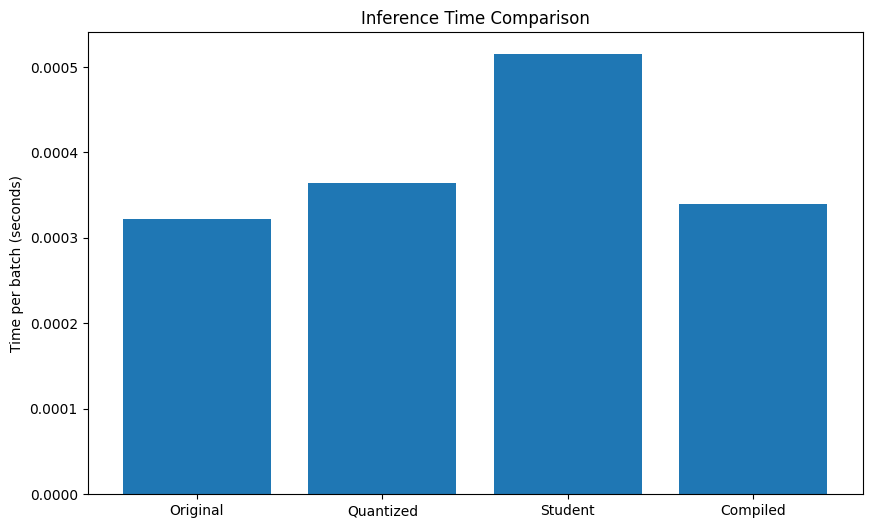

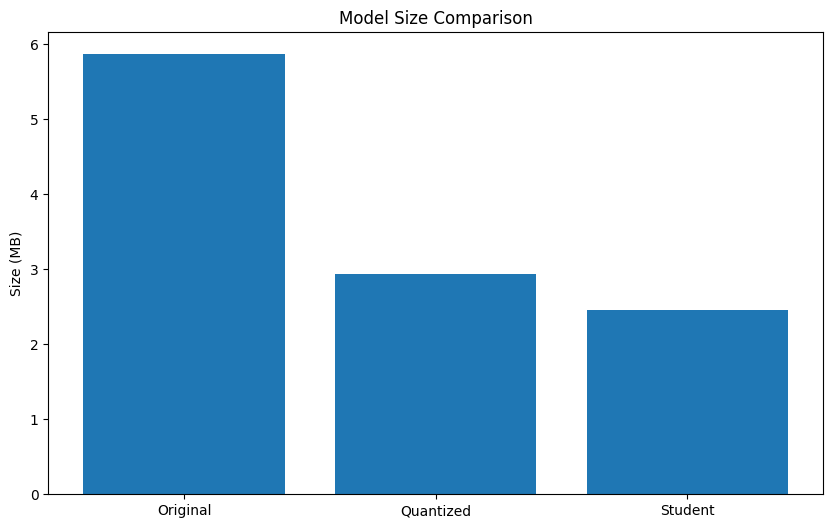

In [19]:
# Step 10: Visualization of results
print("\n--- Visualization ---")
# Plot inference times
models = ["Original", "Quantized", "Student"]
times = [baseline_time, quantized_time, student_time]

if hasattr(torch, 'compile'):
    models.append("Compiled")
    times.append(compiled_time)

plt.figure(figsize=(10, 6))
plt.bar(models, times)
plt.title("Inference Time Comparison")
plt.ylabel("Time per batch (seconds)")
plt.savefig("inference_times.png")
print("Saved inference time comparison to 'inference_times.png'")

# Plot model sizes
def get_model_size(model):
    torch.save(model.state_dict(), "temp_model.pt")
    size = os.path.getsize("temp_model.pt") / (1024 * 1024)  # Size in MB
    os.remove("temp_model.pt")
    return size

# Calculate sizes for all models
original_size = get_model_size(teacher_model.model)
quantized_size = get_model_size(quantized_eval_model.model)
student_size = get_model_size(student_model.model)

sizes = [original_size, quantized_size, student_size]
model_types = ["Original", "Quantized", "Student"]

plt.figure(figsize=(10, 6))
plt.bar(model_types, sizes)
plt.title("Model Size Comparison")
plt.ylabel("Size (MB)")
plt.savefig("model_sizes.png")
print("Saved model size comparison to 'model_sizes.png'")